# MINE minimal working example

This notebook gives an example of computing the mutual information using Mutual Information Neural Estimator (see 1801.04062) using Tensorflow.

It is based on the Torch implementation at: https://github.com/MasanoriYamada/Mine_pytorch

In [1]:
import numpy as np
import tensorflow as tf
import tensorflow.contrib.layers as layers
import matplotlib.pyplot as plt
from sklearn.feature_selection import mutual_info_regression

Generate data of two dependent variables with non zero MI. Compute it analytically and numerically.

In [2]:
# data
var = 0.2
def func(x):
    return x

def gen_x():
    return np.sign(np.random.normal(0.,1.,[data_size,1]))

def gen_y(x):
    return func(x)+np.random.normal(0.,np.sqrt(var),[data_size,1])

data_size = 20000
x=gen_x()
y=gen_y(x)
p_y_x=np.exp(-(y-x)**2/(2*var))
p_y_x_minus=np.exp(-(y+1)**2/(2*var))
p_y_x_plus=np.exp(-(y-1)**2/(2*var))
mi=np.average(np.log(p_y_x/(0.5*p_y_x_minus+0.5*p_y_x_plus)))
print(mi)
mi_numerical = mutual_info_regression(x.reshape(-1, 1), y.ravel())[0]
print(mi_numerical)

0.6575676275599783
0.6580815567734947


Construct the MINE network and train it. Plot convergence of the loss towards true MI.

/Users/zgubic/anaconda3/envs/tf/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


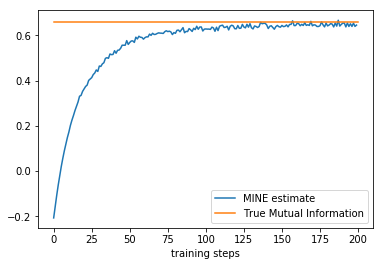

In [3]:
H=20
n_epochs = 200
data_size = 20000

def MINE(x_in, y_in):
    
    # shuffle and concatenate
    y_shuffle = tf.random_shuffle(y_in)
    x_conc = tf.concat([x_in, x_in], axis=0)
    y_conc = tf.concat([y_in, y_shuffle], axis=0)
    
    # propagate the forward pass
    layerx = layers.linear(x_conc, H)
    layery = layers.linear(y_conc, H)
    layer2 = tf.nn.relu(layerx + layery)
    output = layers.linear(layer2, 1)
    
    # split in T_xy and T_x_y predictions
    N_samples = tf.shape(x_in)[0]
    T_xy = output[:N_samples]
    T_x_y = output[N_samples:]
    
    # compute the negative loss (maximise loss == minimise -loss)
    neg_loss = -(tf.reduce_mean(T_xy, axis=0) - tf.math.log(tf.reduce_mean(tf.math.exp(T_x_y))))
    opt = tf.train.AdamOptimizer(learning_rate=0.01).minimize(neg_loss)

    return neg_loss, opt

# prepare the placeholders for inputs
x_in = tf.placeholder(tf.float32, [None, 1], name='x_in')
y_in = tf.placeholder(tf.float32, [None, 1], name='y_in')

# make the loss and optimisation graphs
neg_loss, opt = MINE(x_in, y_in)

# start the session
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

# train
MIs = []
for epoch in range(n_epochs):
    
    # generate the data
    x_sample=gen_x()
    y_sample=gen_y(x_sample)
    
    # perform the training step
    feed_dict = {x_in:x_sample, y_in:y_sample}
    _, neg_l = sess.run([opt, neg_loss], feed_dict=feed_dict)
    
    # save the loss
    MIs.append(-neg_l)

fig, ax = plt.subplots()
ax.plot(range(len(MIs)), MIs, label='MINE estimate')
ax.plot([0, len(MIs)], [mi,mi], label='True Mutual Information')
ax.set_xlabel('training steps')
ax.legend(loc='best')
fig.savefig('MINE.pdf')
fig.show()
